# Advanced Usage - PBMC + IFNb in cell type (CT) scenario

As opposed to previous example, in this tutorial we are going to explore the variation within cell types. 
Given that our dataset, the same as in previous tutorial, has a perturbation and control groups, computing pyroma scores on such subset will capture the variation linked specifically to the IFNb stimulation.

This scenario requires to have predefined CT labels. Alternatively for similar analysis to explore the variation within the population one could perform clustering e.g. Leiden. 

In [ ]:
import os
import zipfile
import io
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
from glob import glob
import time

sc.set_figure_params(figsize=(3, 3), frameon=False )

#os.sys.path.append("/home/az/Downloads/pyroma_tutorial/pyroma/")

import pyroma
roma = pyroma.ROMA()
roma

scROMA

### load the PBMC dataset with IFNb stimulation from Kang et al. 2018

In [2]:
adata = pyroma.datasets.pbmc_ifnb()
adata

AnnData object with n_obs × n_vars = 13576 × 14053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type'

subsmaple to reduce the computation cost

In [3]:
sc.pp.subsample(adata, n_obs=3000)

### standard preprocessing

In [4]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [5]:
adata

AnnData object with n_obs × n_vars = 3000 × 12158
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'n_genes'
    var: 'n_cells'
    uns: 'log1p'

### first look at the data

In [6]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

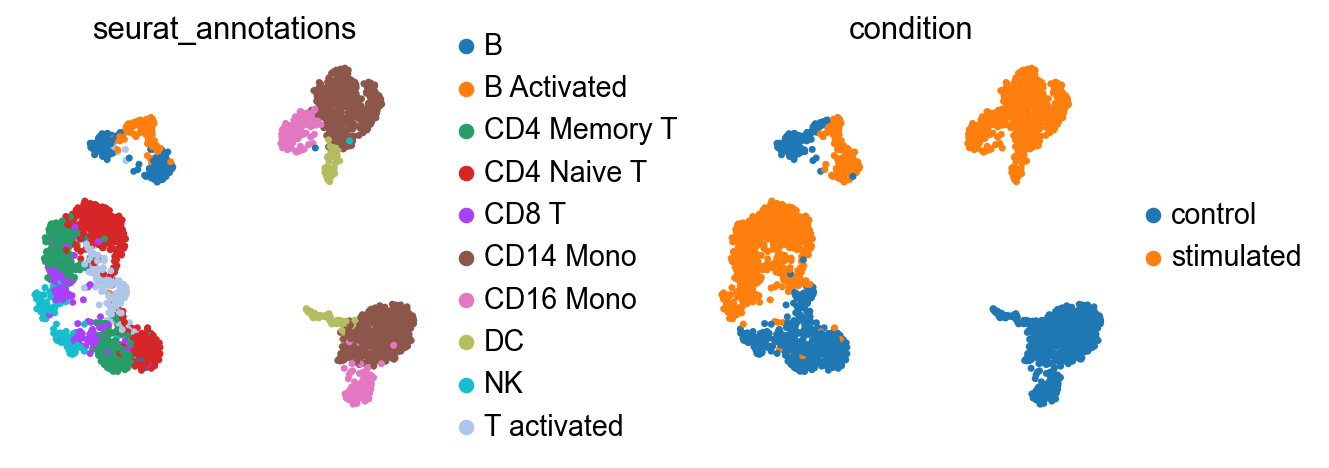

In [7]:
# "seurat_annotations" contain cell type information
# "condition" - is the IFNb stimulation category

sc.pl.umap(adata, color=['seurat_annotations', 'condition'],
           ncols=2,
           wspace=0.5)


### run pyroma

In [8]:
hallmarks_gmt_path = pyroma.genesets.use_hallmarks()

We need to copy the full adata into `sample_adata` to keep it untouched, and then we slice though each cell type adata subset to compute pyroma on it.

In [9]:
iters = 100
ct_label = 'seurat_annotations'

### change to your output directory
output_dir = "/home/az/Downloads/tutorial-test-results/03_pbmc_ifnb_ct/"
sample_name = "kang_sample_all"

sample_adata = adata.copy()
loop_start = time.time()

for ct in sample_adata.obs[ct_label].unique():
    adata = sample_adata[sample_adata.obs[ct_label] == ct].copy()
    if adata.shape[0] < 3:
        continue # skip if there are less than 3 cells
    roma = pyroma.ROMA()
    roma.gmt = hallmarks_gmt_path
    roma.adata = adata
    roma.pc_sign_mode = 'UseMeanExpressionAllWeights'
    pathways_to_check = 'all' 
    
    start = time.time()
    roma.compute(pathways_to_check, 
                parallel=True,
                loocv_on=True,
                iters=iters,
                )
    # the directory to save results will consist of the sample name (if you would like to slice through several samples) + cell type folder
    sample_dir = os.path.join(output_dir, sample_name, ct)
    os.makedirs(sample_dir, exist_ok=True)
    roma.save_active_modules_results(sample_dir, only_active=False)
    
    end = time.time()
    minutes, seconds = divmod(end - start, 60)
    print(f"CPU Parallel {iters} iterations for sample of shape {adata.shape}, running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

loop_end = time.time()
minutes, seconds = divmod(loop_end - loop_start, 60)
print(f"CPU Parallel {iters} iterations, full loop running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

Processing gene set: HALLMARK_NOTCH_SIGNALING | len of subsetlist: 27 
Processing gene set: HALLMARK_HEDGEHOG_SIGNALING | len of subsetlist: 17 
Processing gene set: HALLMARK_ANGIOGENESIS | len of subsetlist: 20 
Processing gene set: HALLMARK_PANCREAS_BETA_CELLS | len of subsetlist: 14 
Processing gene set: HALLMARK_WNT_BETA_CATENIN_SIGNALING | len of subsetlist: 33 
Processing gene set: HALLMARK_APICAL_SURFACE | len of subsetlist: 23 
Processing gene set: HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY | len of subsetlist: 46 
Processing gene set: HALLMARK_TGF_BETA_SIGNALING | len of subsetlist: 48 
Processing gene set: HALLMARK_MYC_TARGETS_V2 | len of subsetlist: 54 
Processing gene set: HALLMARK_CHOLESTEROL_HOMEOSTASIS | len of subsetlist: 61 
Processing gene set: HALLMARK_IL6_JAK_STAT3_SIGNALING | len of subsetlist: 74 
Processing gene set: HALLMARK_PROTEIN_SECRETION | len of subsetlist: 87 
Processing gene set: HALLMARK_INTERFERON_ALPHA_RESPONSE | len of subsetlist: 93 
Processing gene s

### Load results

In [10]:
results_dir = os.path.join(output_dir, sample_name)

folder_data = {}

# Loop through each item in the results_dir
for folder in os.listdir(results_dir):
    folder_path = os.path.join(results_dir, folder)
    if os.path.isdir(folder_path):
        csv_path = os.path.join(folder_path, "ROMA_active_modules.csv") #ROMA_active_modules.csv
        if os.path.exists(csv_path):
            try:
                # Read the CSV. Assuming that the index is meaningful (e.g. module names)
                df = pd.read_csv(csv_path, index_col=0)
                folder_data[folder] = df
                print(f"Loaded active_modules.csv from {folder}")
            except Exception as e:
                print(f"Error reading {csv_path}: {e}")
        else:
            print(f"No active_modules.csv in {folder}")

Loaded active_modules.csv from CD4 Memory T
Loaded active_modules.csv from CD16 Mono
Loaded active_modules.csv from B
Loaded active_modules.csv from B Activated
Loaded active_modules.csv from CD8 T
Loaded active_modules.csv from DC
Loaded active_modules.csv from CD4 Naive T
Loaded active_modules.csv from T activated
Loaded active_modules.csv from NK
Loaded active_modules.csv from CD14 Mono


In each of the ct run - we have statistical significance estimation, that is then could be retrieved from `folder_data' dictionary.

In [11]:
folder_data

{'CD4 Memory T': Empty DataFrame
 Columns: [L1, ppv L1, Median Exp, ppv Med Exp, q L1, q Med Exp]
 Index: [],
 'CD16 Mono': Empty DataFrame
 Columns: [L1, ppv L1, Median Exp, ppv Med Exp, q L1, q Med Exp]
 Index: [],
 'B': Empty DataFrame
 Columns: [L1, ppv L1, Median Exp, ppv Med Exp, q L1, q Med Exp]
 Index: [],
 'B Activated':                                L1  ppv L1  Median Exp  ppv Med Exp  q L1  \
 HALLMARK_UV_RESPONSE_DN  0.463133     0.0   -0.004063     0.584158   0.0   
 
                          q Med Exp  
 HALLMARK_UV_RESPONSE_DN   0.913938  ,
 'CD8 T': Empty DataFrame
 Columns: [L1, ppv L1, Median Exp, ppv Med Exp, q L1, q Med Exp]
 Index: [],
 'DC': Empty DataFrame
 Columns: [L1, ppv L1, Median Exp, ppv Med Exp, q L1, q Med Exp]
 Index: [],
 'CD4 Naive T': Empty DataFrame
 Columns: [L1, ppv L1, Median Exp, ppv Med Exp, q L1, q Med Exp]
 Index: [],
 'T activated': Empty DataFrame
 Columns: [L1, ppv L1, Median Exp, ppv Med Exp, q L1, q Med Exp]
 Index: [],
 'NK': Empty Da

In [12]:
sample_adata

AnnData object with n_obs × n_vars = 3000 × 12158
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'n_genes'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'seurat_annotations_colors', 'condition_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [13]:
#results_dir

for ct in sample_adata.obs[ct_label].unique():
    adata = sample_adata[sample_adata.obs[ct_label] == ct].copy()
    roma = pyroma.ROMA()
    roma.adata = adata
    
    # here it loads all the pathways (not only stat. sig. ones) 
    roma.load_active_modules_results(os.path.join(results_dir, ct))
    pyroma.integrate_projection_results(sample_adata, ct, roma.adata.uns['ROMA'], ct_label)

Projection columns for cell type 'CD8 T' integrated successfully.
Projection columns for cell type 'CD14 Mono' integrated successfully.
Projection columns for cell type 'NK' integrated successfully.
Projection columns for cell type 'B Activated' integrated successfully.
Projection columns for cell type 'CD4 Naive T' integrated successfully.
Projection columns for cell type 'B' integrated successfully.
Projection columns for cell type 'T activated' integrated successfully.
Projection columns for cell type 'CD16 Mono' integrated successfully.
Projection columns for cell type 'CD4 Memory T' integrated successfully.
Projection columns for cell type 'DC' integrated successfully.


In [14]:
# raw CT pyroma scores are in .uns['pyroma_scores]

In [15]:
sample_adata

AnnData object with n_obs × n_vars = 3000 × 12158
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'n_genes'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'seurat_annotations_colors', 'condition_colors', 'pyroma_scores'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [16]:
sample_adata.uns['pyroma_scores']

,CD8 T|HALLMARK_BILE_ACID_METABOLISM,CD8 T|HALLMARK_IL2_STAT5_SIGNALING,CD8 T|HALLMARK_MYOGENESIS,CD8 T|HALLMARK_INTERFERON_ALPHA_RESPONSE,CD8 T|HALLMARK_ALLOGRAFT_REJECTION,CD8 T|HALLMARK_MTORC1_SIGNALING,CD8 T|HALLMARK_XENOBIOTIC_METABOLISM,CD8 T|HALLMARK_UNFOLDED_PROTEIN_RESPONSE,CD8 T|HALLMARK_ANGIOGENESIS,CD8 T|HALLMARK_GLYCOLYSIS,...,DC|HALLMARK_NOTCH_SIGNALING,DC|HALLMARK_INTERFERON_GAMMA_RESPONSE,DC|HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,DC|HALLMARK_CHOLESTEROL_HOMEOSTASIS,DC|HALLMARK_PEROXISOME,DC|HALLMARK_KRAS_SIGNALING_UP,DC|HALLMARK_P53_PATHWAY,DC|HALLMARK_INFLAMMATORY_RESPONSE,DC|HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,DC|HALLMARK_PANCREAS_BETA_CELLS
index,,,,,,,,,,,,,,,,,,,,,
TGTGAGACATTCCT.1,0.078277,-0.031965,-0.080842,-0.076393,-0.059486,0.071351,-0.059144,-0.102842,-0.045540,-0.100340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGAGTTTGAAGATG.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CGGCATCTCGTAGT.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGAATACTTCCTGC.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACGATTCTGTGTAC.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCAAACTGCTCAGA.1,-0.083255,-0.022381,0.058903,0.071822,0.033784,0.004742,0.166854,-0.036657,0.059809,0.044486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GACTGAACATCTCT.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGGTAACTGTCTAG.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can plot these raw CT scores 

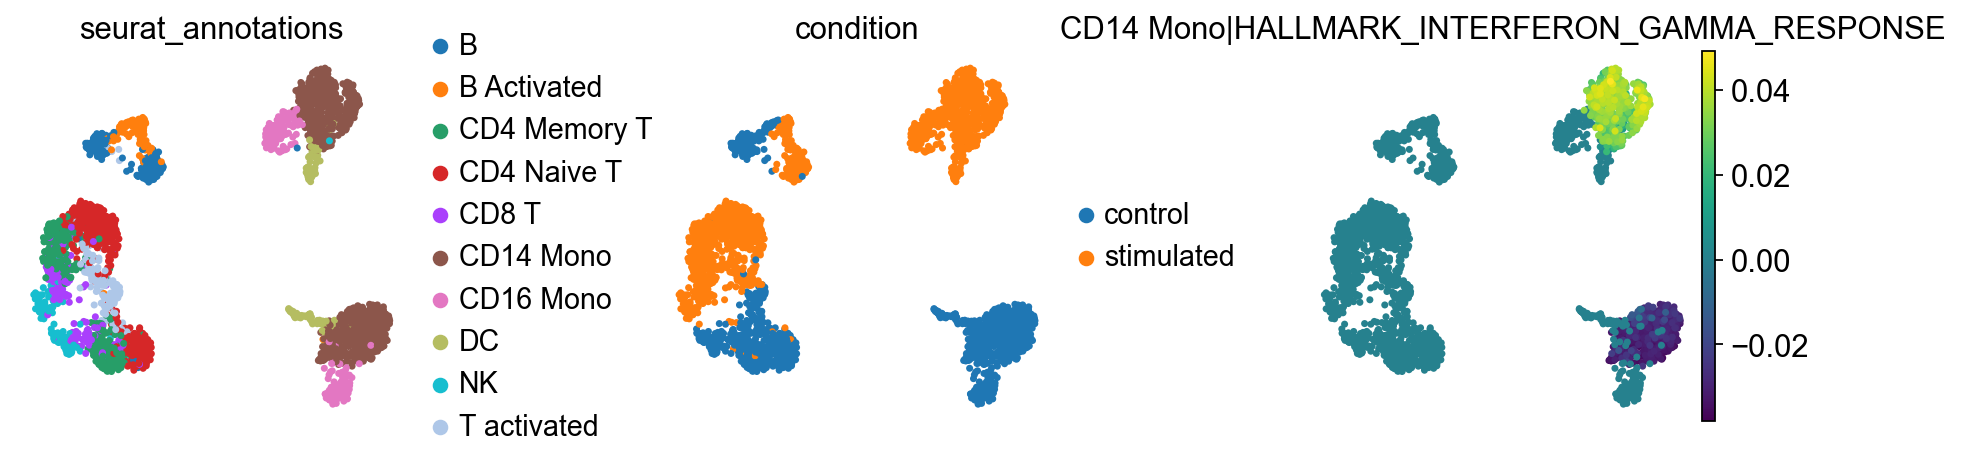

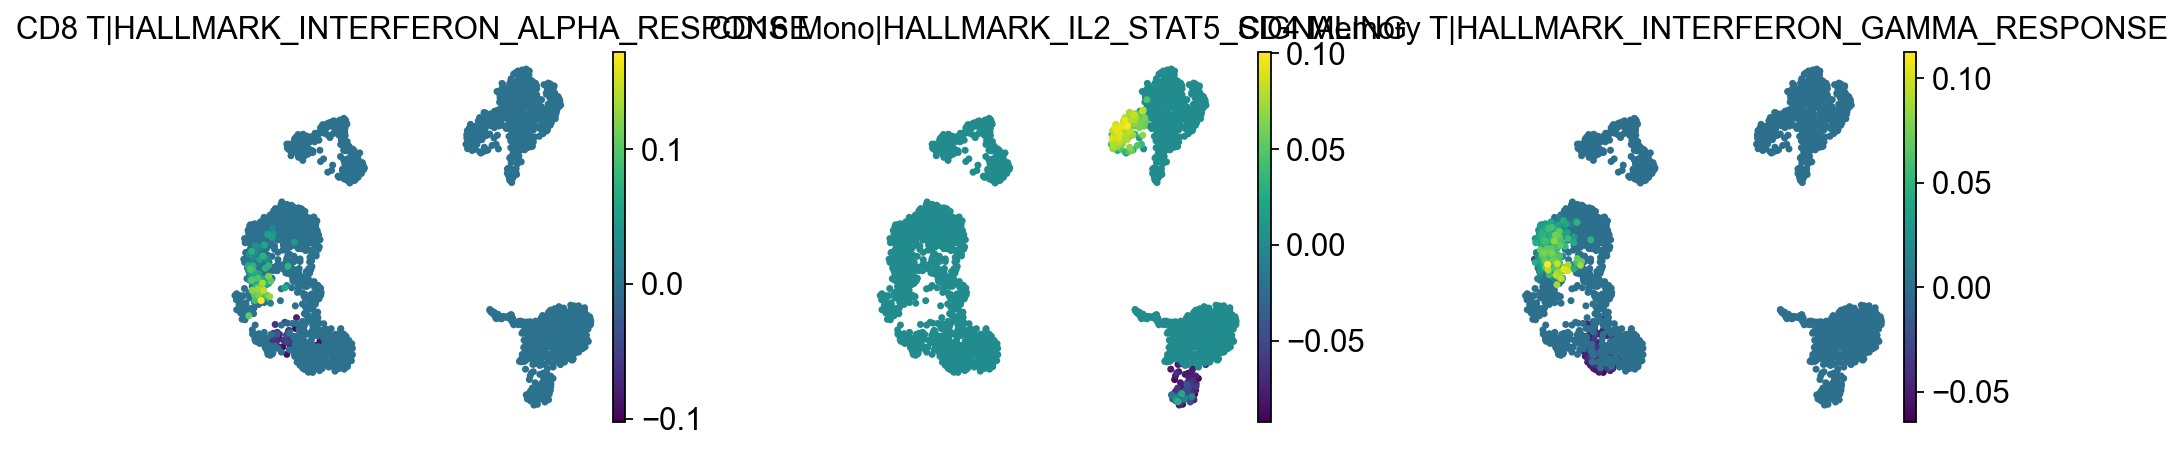

In [17]:
ct_score = 'CD14 Mono|HALLMARK_INTERFERON_GAMMA_RESPONSE'
sample_adata.obs[ct_score] = sample_adata.uns['pyroma_scores'][ct_score]

sc.pl.umap(sample_adata, color=['seurat_annotations', 'condition', ct_score] ,
           ncols=3,
           wspace=0.5)

ct_score_2 = 'CD8 T|HALLMARK_INTERFERON_ALPHA_RESPONSE'
ct_score_3 = 'CD16 Mono|HALLMARK_IL2_STAT5_SIGNALING'
ct_score_4 = 'CD4 Memory T|HALLMARK_INTERFERON_GAMMA_RESPONSE'
sample_adata.obs[ct_score_2] = sample_adata.uns['pyroma_scores'][ct_score_2]
sample_adata.obs[ct_score_3] = sample_adata.uns['pyroma_scores'][ct_score_3]
sample_adata.obs[ct_score_4] = sample_adata.uns['pyroma_scores'][ct_score_4]
sc.pl.umap(sample_adata, color=[ct_score_2, ct_score_3, ct_score_4 ] ,
           ncols=3,
           wspace=0.5)


In order to have global gene set scores we need to aggregate the CT scores per one gene set across all cell types and normalize them. One could explore more deeply what way of aggregating and normalizing these score fit better for their purpose.

In [51]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scores = sample_adata.uns['pyroma_scores'].copy()

z_scores = np.zeros_like(scores)

z_scaler = StandardScaler()
z_scores = z_scaler.fit_transform(scores)

z_scores = pd.DataFrame(z_scores, index=sample_adata.obs_names, columns=scores.columns)

# build a mapping col → pathway by splitting on the first ‘|’
pathway_map = {
    col: col.split('|', 1)[1]
    for col in z_scores.columns
}

# use DataFrame.groupby over axis=1 with that mapping.
#    here we sum—since only the matching cell‐type column is nonzero, sum==pick—but you
#    could also use max, mean, median, etc.
def max_abs_dataframe(df):
    return df.apply(lambda row: row.loc[row.abs().idxmax()], axis=1)

collapsed = z_scores.groupby(pathway_map, axis=1).sum()  #apply(max_abs_dataframe)

# collapsed is now shape (n_cells, n_unique_pathways), with each cell’s score
# for each gene set aggregated across all cell types.

sample_adata.obsm['pyroma_pathway_scores_summed'] = collapsed


### create scores anndata 
`sample_adata.obsm['pyroma_pathway_scores_summed']` contain pyroma CT scores equivalent to pyroma scores from tutorial #2. We can convert them to simple anndata of shape (cells x genesets)

In [52]:
def scores_to_adata(sample_adata, obsm_key: str):
    from anndata import AnnData
    X_obsm = sample_adata.obsm[obsm_key]
    obs = sample_adata.obs
    var = pd.DataFrame(index=X_obsm.columns)
    X = X_obsm.values
    uns = sample_adata.uns
    obsm = sample_adata.obsm
    score_adata = AnnData(X=X, obs=obs, var=var, uns=uns, obsm=obsm)
    return score_adata

scores_adata = scores_to_adata(sample_adata, obsm_key='pyroma_pathway_scores_summed')
scores_adata

AnnData object with n_obs × n_vars = 3000 × 50
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'n_genes', 'CD14 Mono|HALLMARK_INTERFERON_GAMMA_RESPONSE', 'CD8 T|HALLMARK_INTERFERON_ALPHA_RESPONSE', 'CD16 Mono|HALLMARK_IL2_STAT5_SIGNALING', 'CD4 Memory T|HALLMARK_INTERFERON_GAMMA_RESPONSE'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'seurat_annotations_colors', 'condition_colors', 'pyroma_scores', 'seurat_condition_colors'
    obsm: 'X_pca', 'X_umap', 'pyroma_pathway_scores_summed'

In [53]:
# put your directory 
sc.set_figure_params(figsize=(4, 4), frameon=False )
save_dir = "/home/az/Downloads/pyroma_tutorial/03_pbmc_study/01_kang_3k_ct"
os.makedirs(save_dir, exist_ok=True)
sc.settings.figdir = save_dir

... storing 'seurat_condition' as categorical


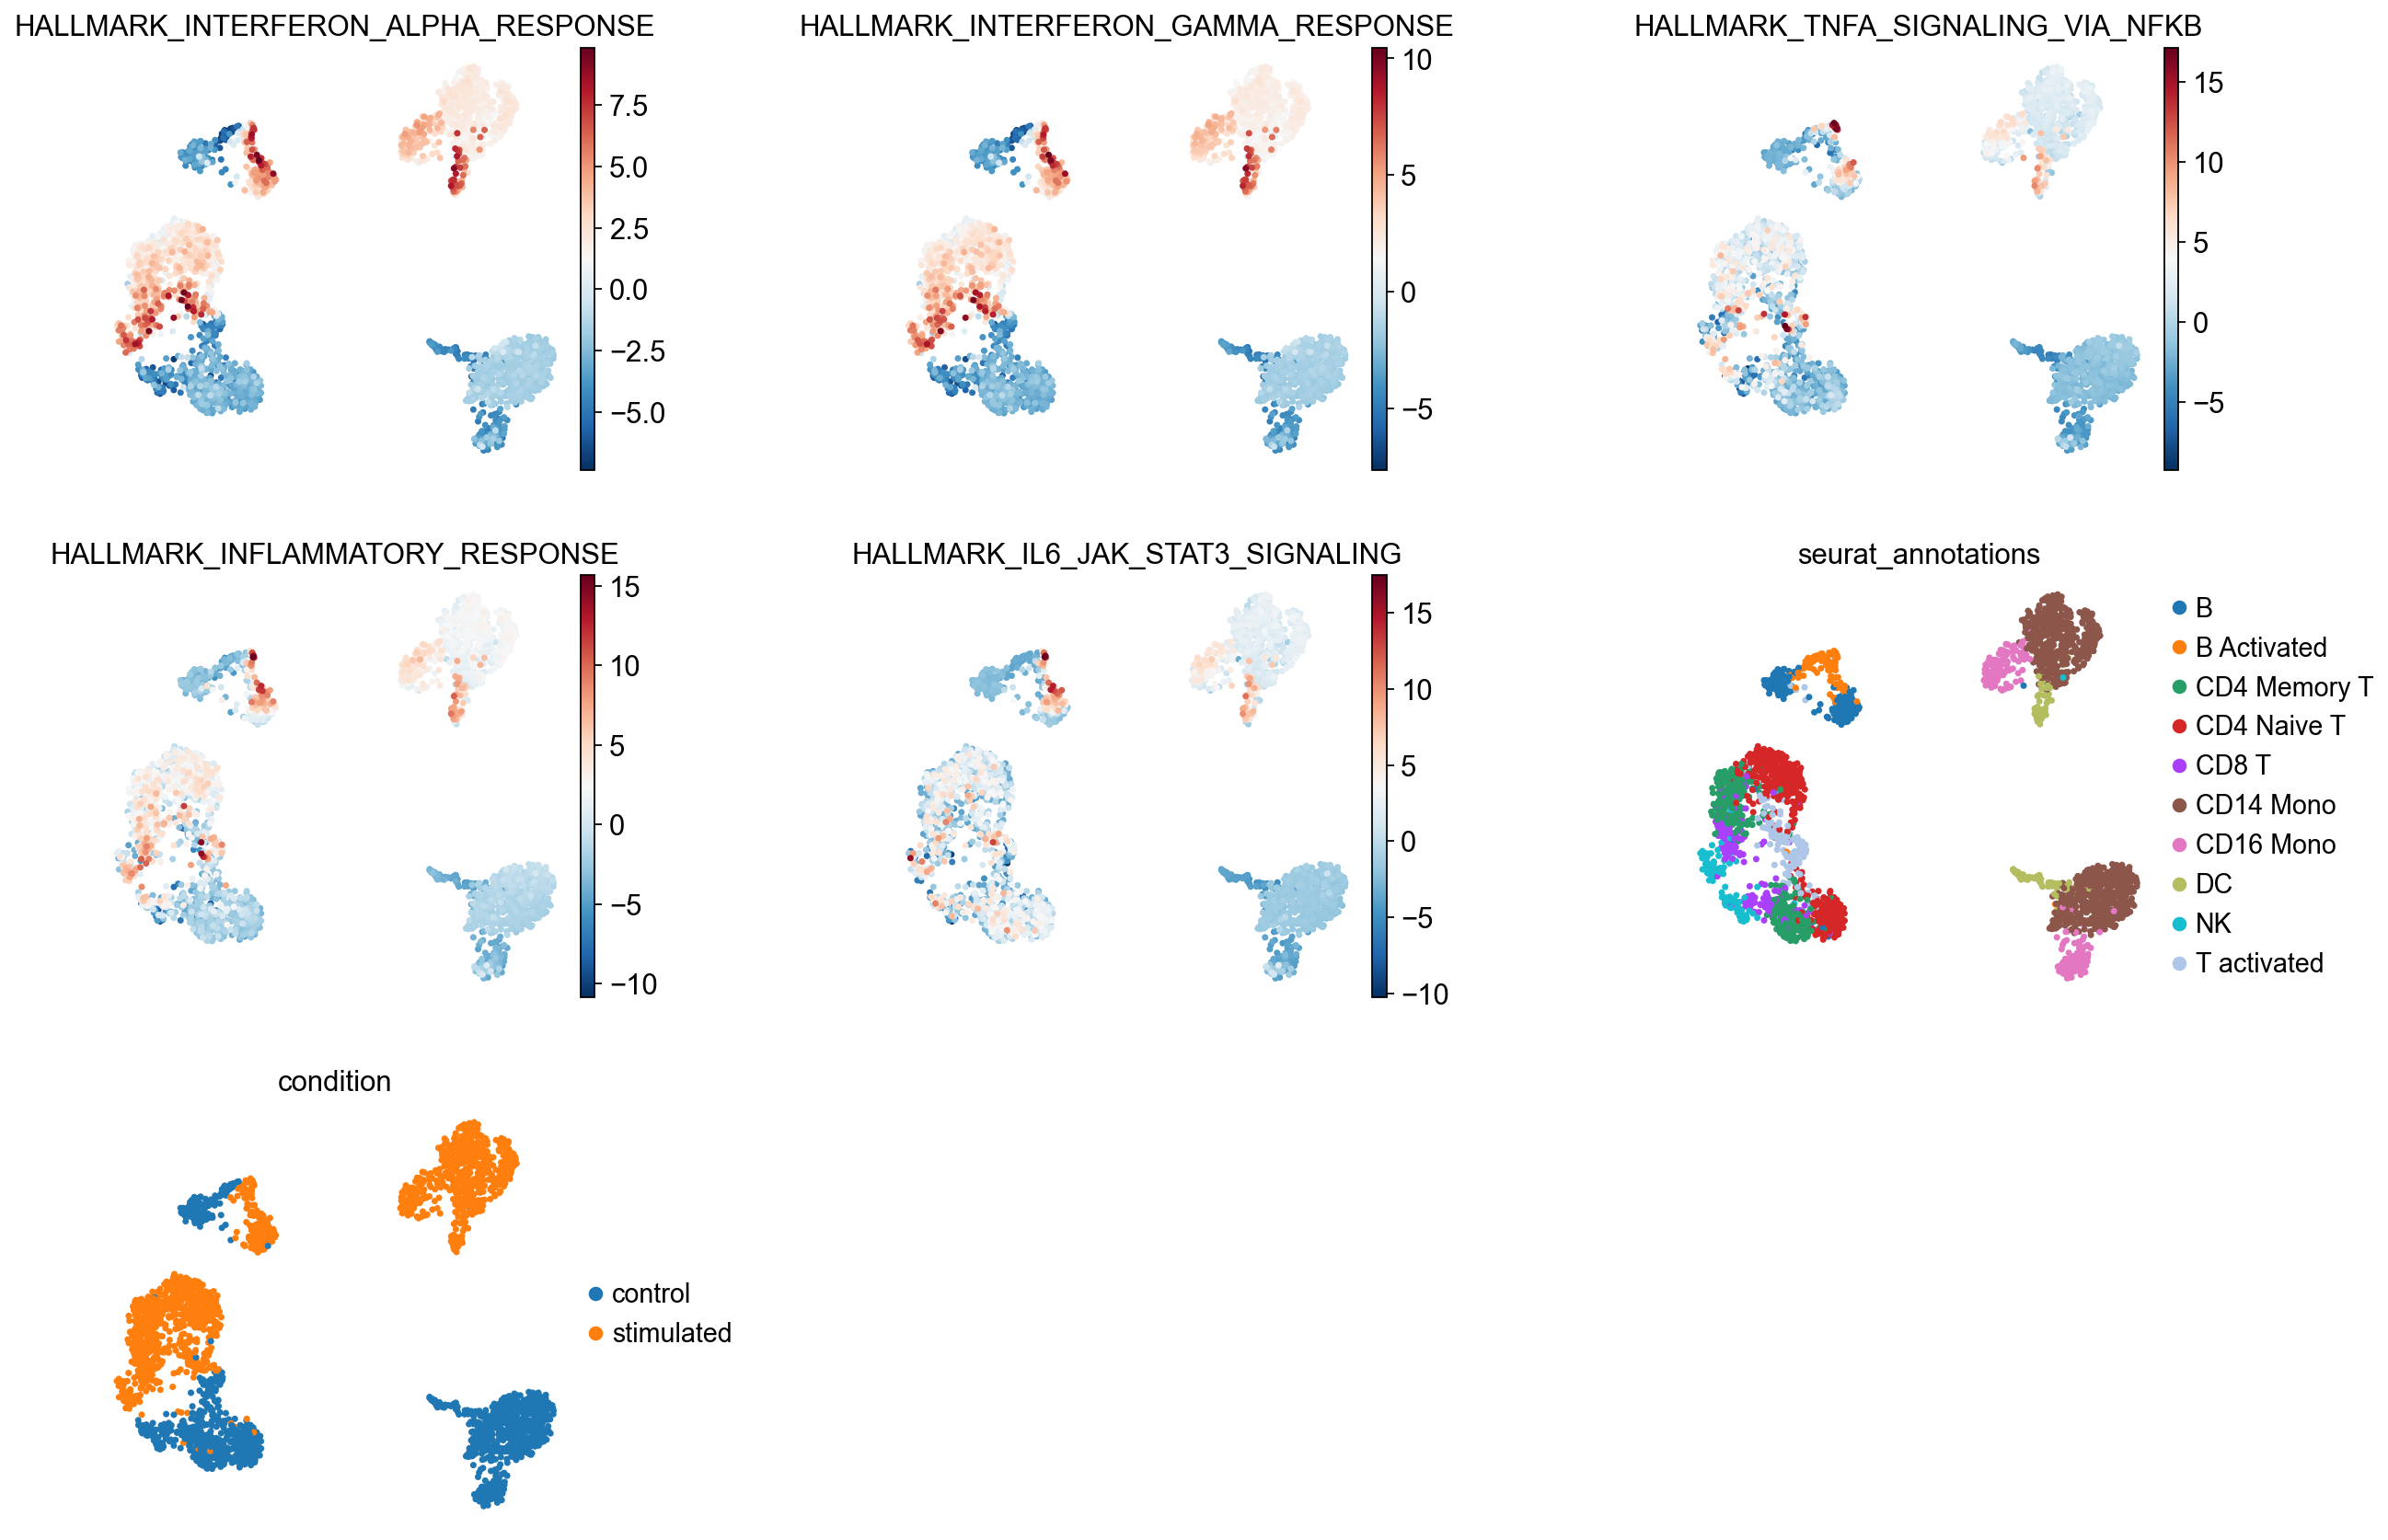

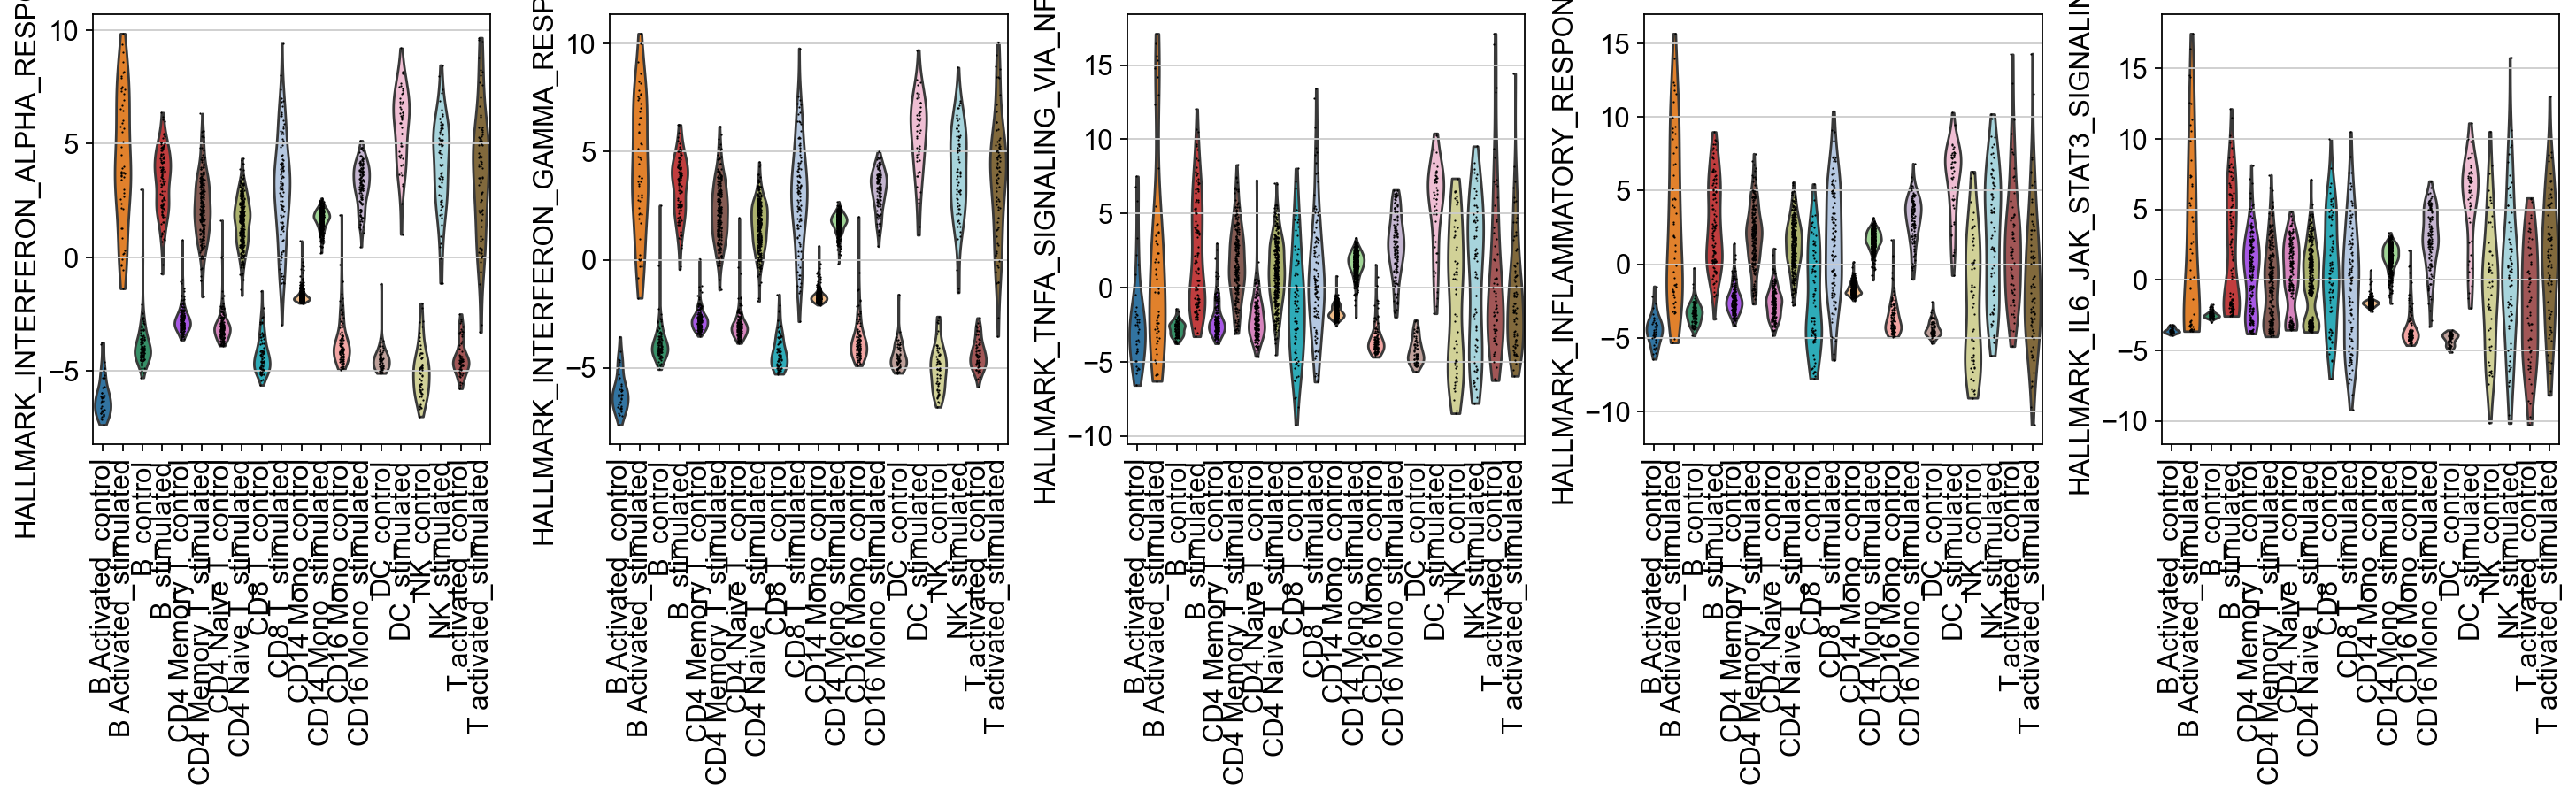

In [54]:
scores_adata.obs['seurat_condition'] = scores_adata.obs['seurat_annotations'].astype(str) + '_' + scores_adata.obs['condition'].astype(str)

pathways = ["HALLMARK_INTERFERON_ALPHA_RESPONSE", "HALLMARK_INTERFERON_GAMMA_RESPONSE",
            "HALLMARK_TNFA_SIGNALING_VIA_NFKB", "HALLMARK_INFLAMMATORY_RESPONSE", 
            "HALLMARK_IL6_JAK_STAT3_SIGNALING" ]
save_name = "_Key Pathways Activated Upon Stimulation_zscores_adatas_summed"

sc.pl.umap(scores_adata, color=pathways + ['seurat_annotations', 'condition'], 
           cmap='RdBu_r', ncols=3, wspace=0.5, 
           save=f"{save_name}.png")

sc.pl.violin(scores_adata, keys=pathways, 
                         groupby='seurat_condition', 
                        rotation=90,
                        save=f'{save_name}.png')

### rank gene sets by 'cell type + condition' group
To perform ranking of gene sets by groups we could use the package decoupler from scverse.
https://decoupler.readthedocs.io/en/latest/ .
To install run: 

`pip install decoupler`

after installing it in the same environment we can call import it and perform the ranking, which would identify top n genesets per group (e.g. CD14 Monocytes stimulated).

In [55]:
import decoupler as dc

df = dc.tl.rankby_group(adata=scores_adata, groupby="seurat_condition", reference="rest", method="t-test_overestim_var")
df = df[df["stat"] > 0]
df

,group,reference,name,stat,meanchange,pval,padj
4,CD8 T_control,rest,HALLMARK_ESTROGEN_RESPONSE_LATE,9.523801,4.142254,9.974085e-17,9.974085e-16
14,CD8 T_control,rest,HALLMARK_MTORC1_SIGNALING,3.080557,1.769522,2.478203e-03,8.260676e-03
19,CD8 T_control,rest,HALLMARK_MYC_TARGETS_V2,1.674365,1.040178,9.637831e-02,2.338365e-01
23,CD8 T_control,rest,HALLMARK_CHOLESTEROL_HOMEOSTASIS,1.507565,0.921257,1.339736e-01,2.791116e-01
25,CD8 T_control,rest,HALLMARK_SPERMATOGENESIS,1.290366,0.791707,1.991087e-01,3.769849e-01
...,...,...,...,...,...,...,...
992,B Activated_control,rest,HALLMARK_E2F_TARGETS,0.389469,0.369693,6.982309e-01,7.840861e-01
993,B Activated_control,rest,HALLMARK_UV_RESPONSE_DN,0.357452,0.352716,7.219773e-01,7.840861e-01
996,B Activated_control,rest,HALLMARK_G2M_CHECKPOINT,0.337274,0.326726,7.370410e-01,7.840861e-01
997,B Activated_control,rest,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.315923,0.311829,7.531310e-01,7.845115e-01


In [56]:
n_markers = 3
source_markers = (
    df.groupby("group")
    .head(n_markers)
    .drop_duplicates("name")
    .groupby("group")["name"]
    .apply(lambda x: list(x))
    .to_dict()
)
source_markers

{'B Activated_control': ['HALLMARK_COMPLEMENT'],
 'B Activated_stimulated': [],
 'B_control': [],
 'B_stimulated': [],
 'CD14 Mono_control': ['HALLMARK_P53_PATHWAY', 'HALLMARK_MYC_TARGETS_V1'],
 'CD14 Mono_stimulated': ['HALLMARK_INTERFERON_ALPHA_RESPONSE',
  'HALLMARK_INTERFERON_GAMMA_RESPONSE',
  'HALLMARK_APOPTOSIS'],
 'CD16 Mono_control': [],
 'CD16 Mono_stimulated': [],
 'CD4 Memory T_control': ['HALLMARK_IL2_STAT5_SIGNALING',
  'HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY'],
 'CD4 Memory T_stimulated': [],
 'CD4 Naive T_control': ['HALLMARK_UV_RESPONSE_UP',
  'HALLMARK_HEME_METABOLISM'],
 'CD4 Naive T_stimulated': [],
 'CD8 T_control': ['HALLMARK_ESTROGEN_RESPONSE_LATE',
  'HALLMARK_MTORC1_SIGNALING',
  'HALLMARK_MYC_TARGETS_V2'],
 'CD8 T_stimulated': [],
 'DC_control': ['HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_ADIPOGENESIS'],
 'DC_stimulated': [],
 'NK_control': ['HALLMARK_HYPOXIA',
  'HALLMARK_GLYCOLYSIS',
  'HALLMARK_KRAS_SIGNALING_UP'],
 'NK_stimulated': [],
 'T activated_c

### end